In [1]:
%matplotlib inline
import matplotlib.pyplot as plt 
plt.style.use( 'ggplot' ) 

In [2]:
import pandas 
from sklearn.preprocessing import MinMaxScaler
import numpy as np 
import pickle
from scipy.stats import pearsonr

# Feature sets 

This notebook collects the various feature sets from molecular modeling (in `*runs/*/feature_set.csv'`), and matches them up with the various targets (for now, melting temperature, turnover number, substrate affinity, and efficiency) for input to machine learning algorithms

In [3]:
feature_sets = [ 
    # rosetta 
    '../rosetta_runs/benchmark/feature_set.csv', 
    '../rosetta_runs/shells/feature_set.csv',
    '../rosetta_runs/ddg_monomer/feature_set.csv', 
    '../rosetta_runs/new_protocol/feature_set.csv', 
    
    # pyrosetta 
    '../pyrosetta_runs/beta/feature_set.csv', 
    
    # foldx 
    '../foldx_runs/pssm/feature_set.csv', 
    
    # dreaming 
    # '../rosetta_runs/homology_models/feature_set.csv', 
]

In [4]:
#experimental_data 
dat = pandas.read_csv( '../data_sets/experimental/targets.csv', index_col=0 )
#dat.kcat = np.log10( dat.kcat / 880 )
#dat.km = np.log10( dat.km / 5.5 )
#dat.kcatkm = np.log10( dat.kcatkm / 174000 )
#dat = dat.replace( [ np.inf, -np.inf ], -5 )

In [5]:
dat.sample( 6 ) 

,expression,tm,kcat,km,kcatkm
mutant,,,,,
C167A,1,-0.09,-0.264147,-0.464191,-0.723565
W325L,1,2.69,-0.907056,-0.059942,-0.963881
S17A,1,1.73,-0.016087,-0.567026,-0.577999
S16A,1,-0.52,-0.756962,-0.447468,-1.199275
G12N,0,NaN,NaN,NaN,NaN
H379R,1,NaN,NaN,NaN,-4.240549


In [6]:
targets = [ 'kcat', 'km', 'kcatkm', 'tm' ] 

In [10]:
combos = []
for feature_set in feature_sets:
    
    # read in feature set 
    feats = pandas.read_csv( feature_set, index_col=0 )
    # short name for display 
    name = feature_set.split( '/' )[2]
    
    # join feature sets with targets 
    for target in targets:
        
        # join feature set with target and remove rows and columns with NaN entries 
        J = dat[[ target ]].join( feats ).dropna()
        print( J.shape, name, target ) 
        
        # scale the features to the [0,1] interval 
        scaler = MinMaxScaler()
        X = scaler.fit_transform( J )
        
        # get all columns except first one (first is target col) 
        X = X[ : , 1: ] 
        
        # reshape target to a 1-D array for sklearn 
        y = J.ix[ : , 0 ].ravel()
        
        # append a combo tuple 
        # include names of columns since the scaler returns an unlabeled NumPy array 
        support = J.columns[ 1: ] # feature names 
        combos.append( ( name, target, X, y, support ) )

(73, 60) benchmark kcat
(73, 60) benchmark km
(87, 60) benchmark kcatkm
(76, 60) benchmark tm
(74, 60) shells kcat
(74, 60) shells km
(85, 60) shells kcatkm
(77, 60) shells tm
(73, 15) ddg_monomer kcat
(73, 15) ddg_monomer km
(88, 15) ddg_monomer kcatkm
(76, 15) ddg_monomer tm
(74, 60) new_protocol kcat
(74, 60) new_protocol km
(86, 60) new_protocol kcatkm
(77, 60) new_protocol tm
(73, 27) beta kcat
(73, 27) beta km
(85, 27) beta kcatkm
(76, 27) beta tm
(74, 17) pssm kcat
(74, 17) pssm km
(89, 17) pssm kcatkm
(77, 17) pssm tm


In [11]:
with open( 'combos.pkl', 'wb' ) as fn:
    pickle.dump( combos, fn ) 

## Feature distributions

Here, we attempt to make a compact representation of the feature ranges in the feature set. Each plot is titled with the feature set name and target name (each feature set has different mutants in it, depending on the target). Each feature has been normalized to the [0,1] interval. The number in parentheses after the feature name is the Pearson correlation coefficient for the individual feature to the target.

/usr/local/bin/anaconda3/lib/python3.5/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


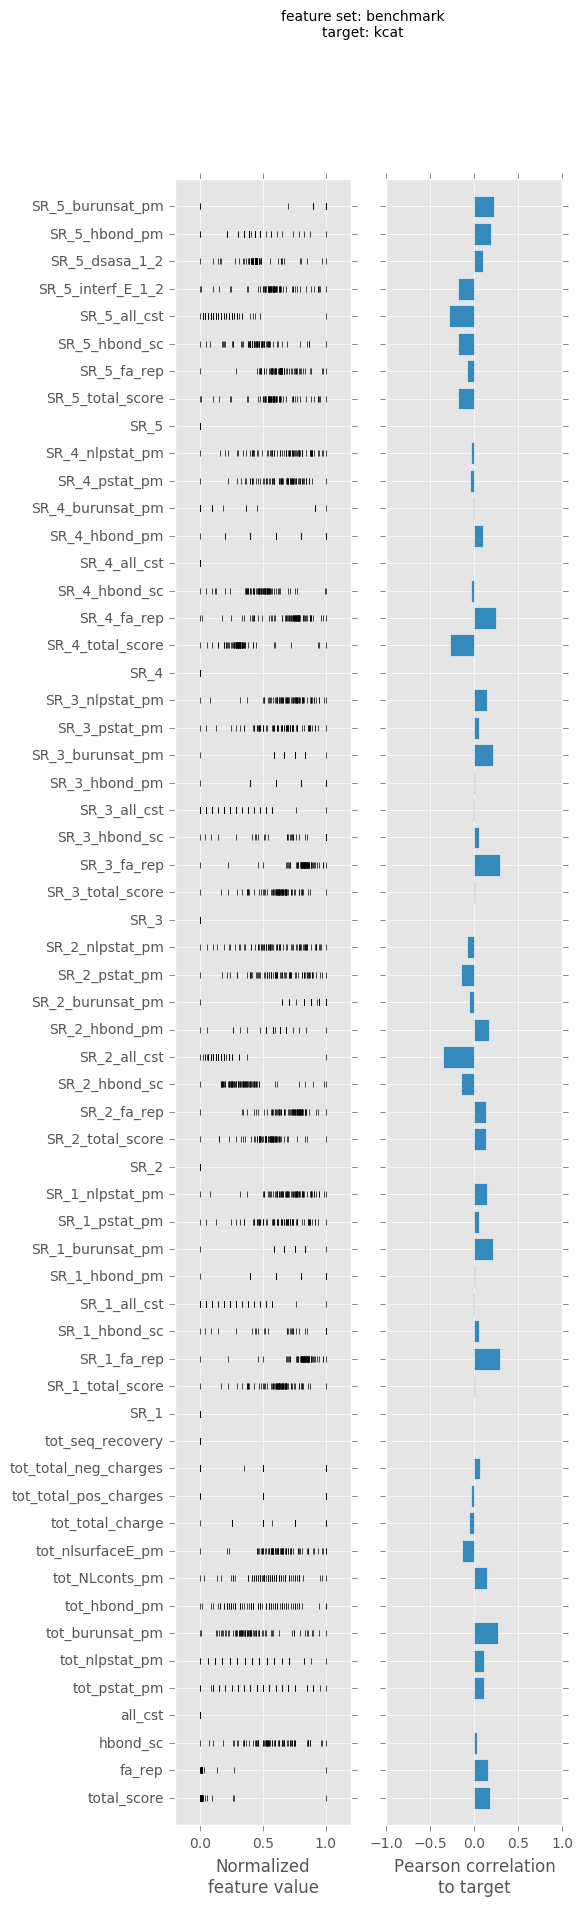

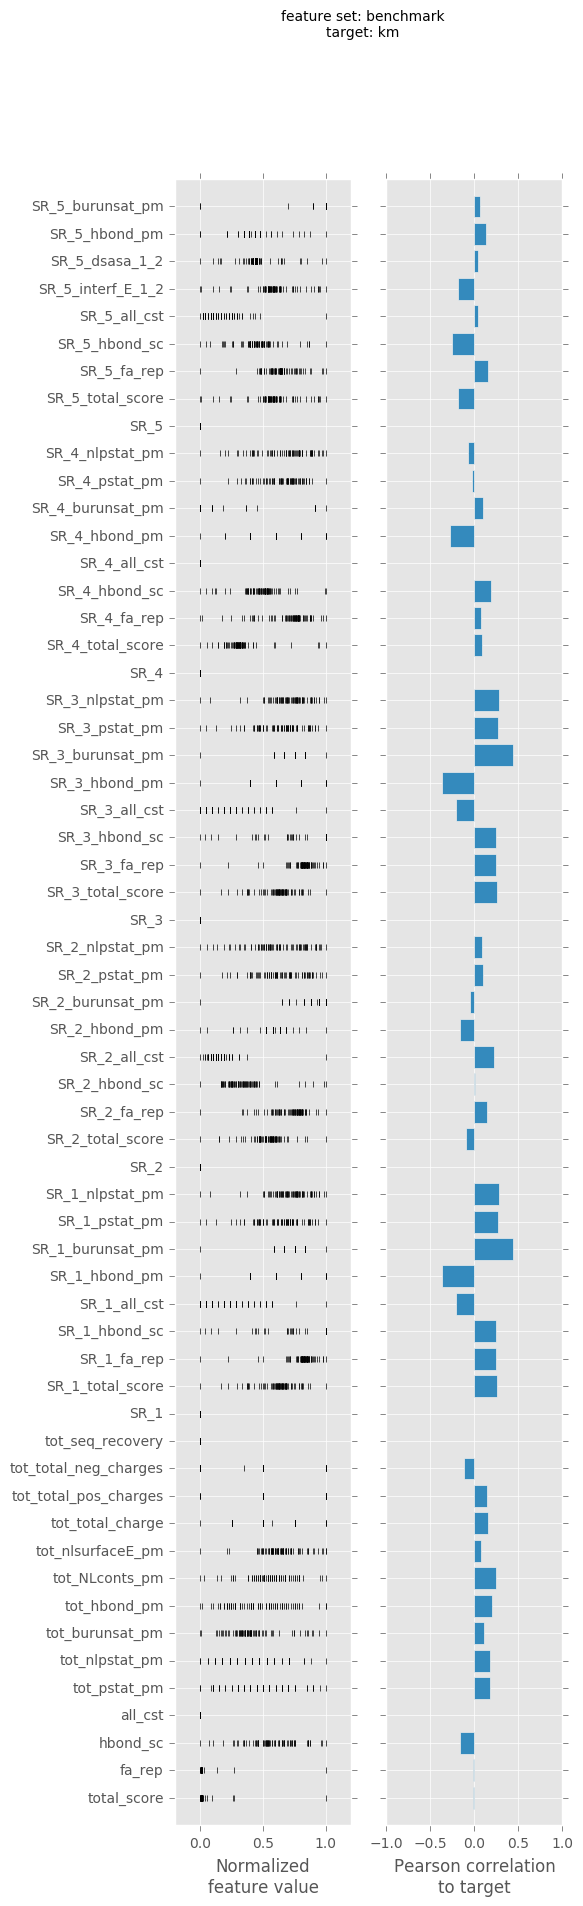

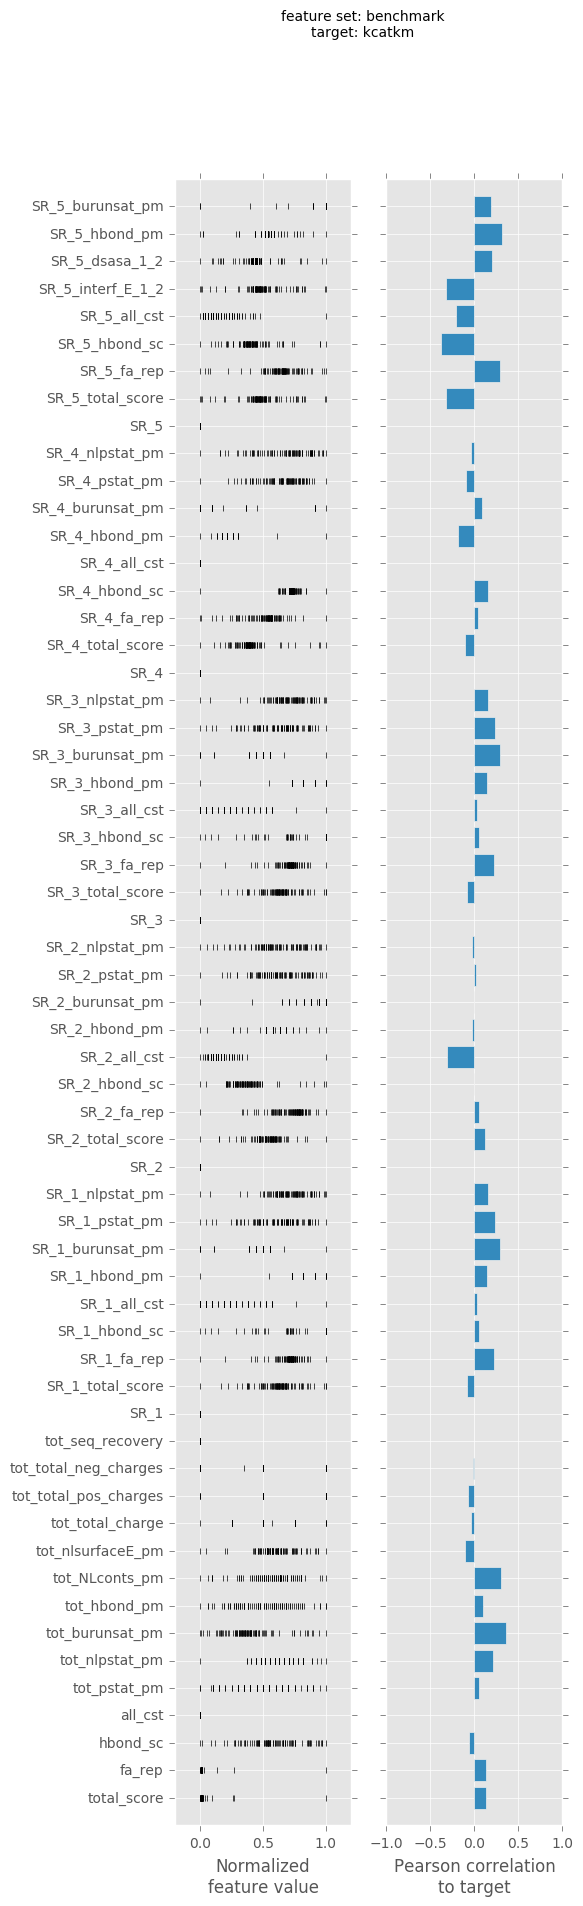

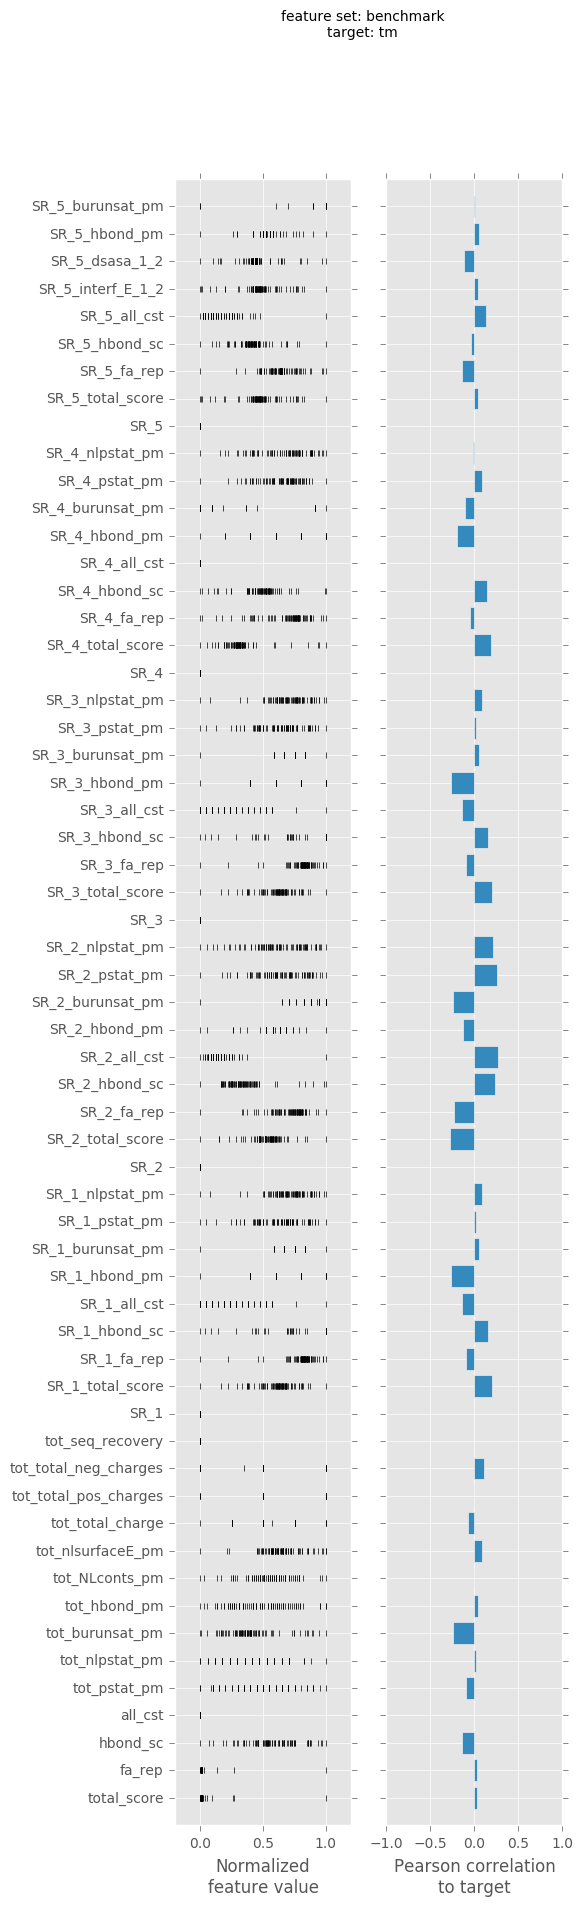

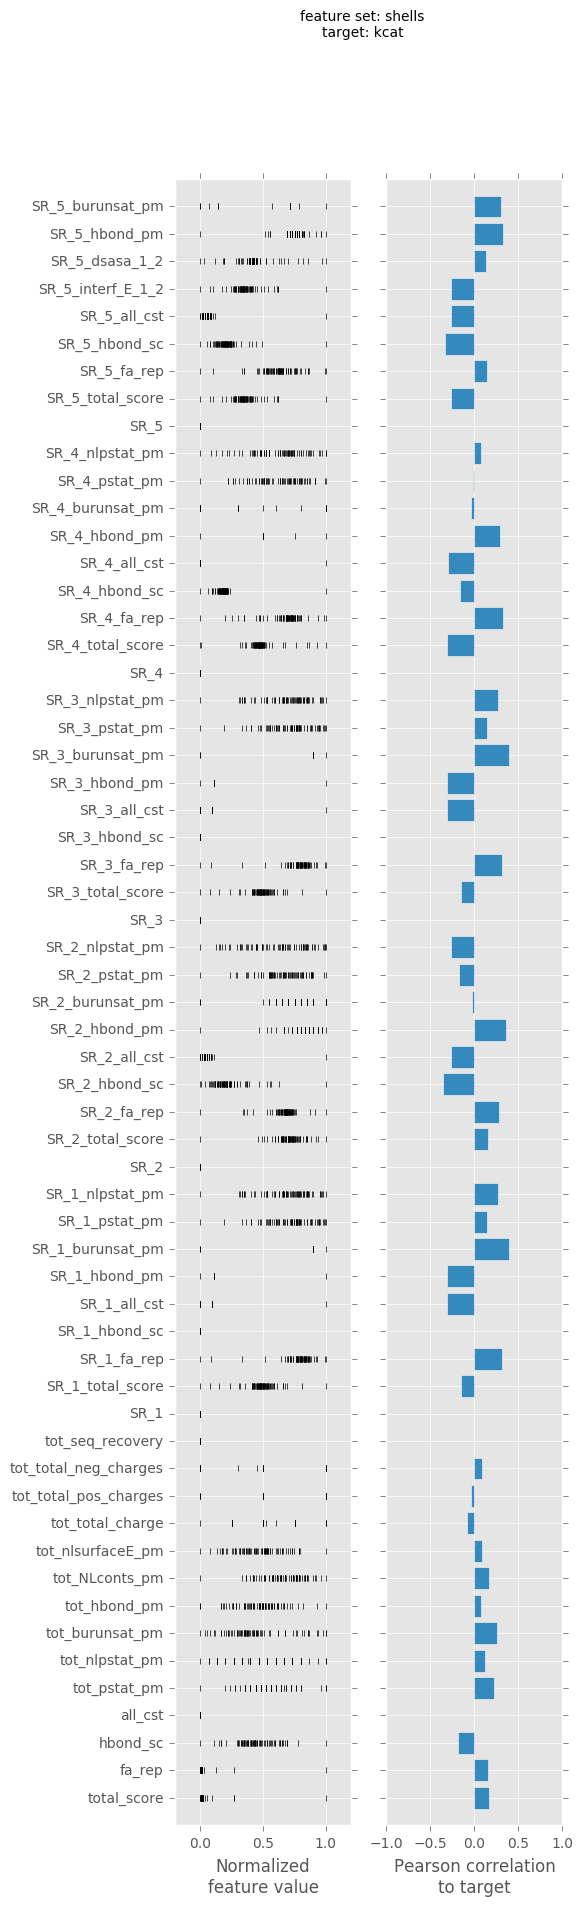

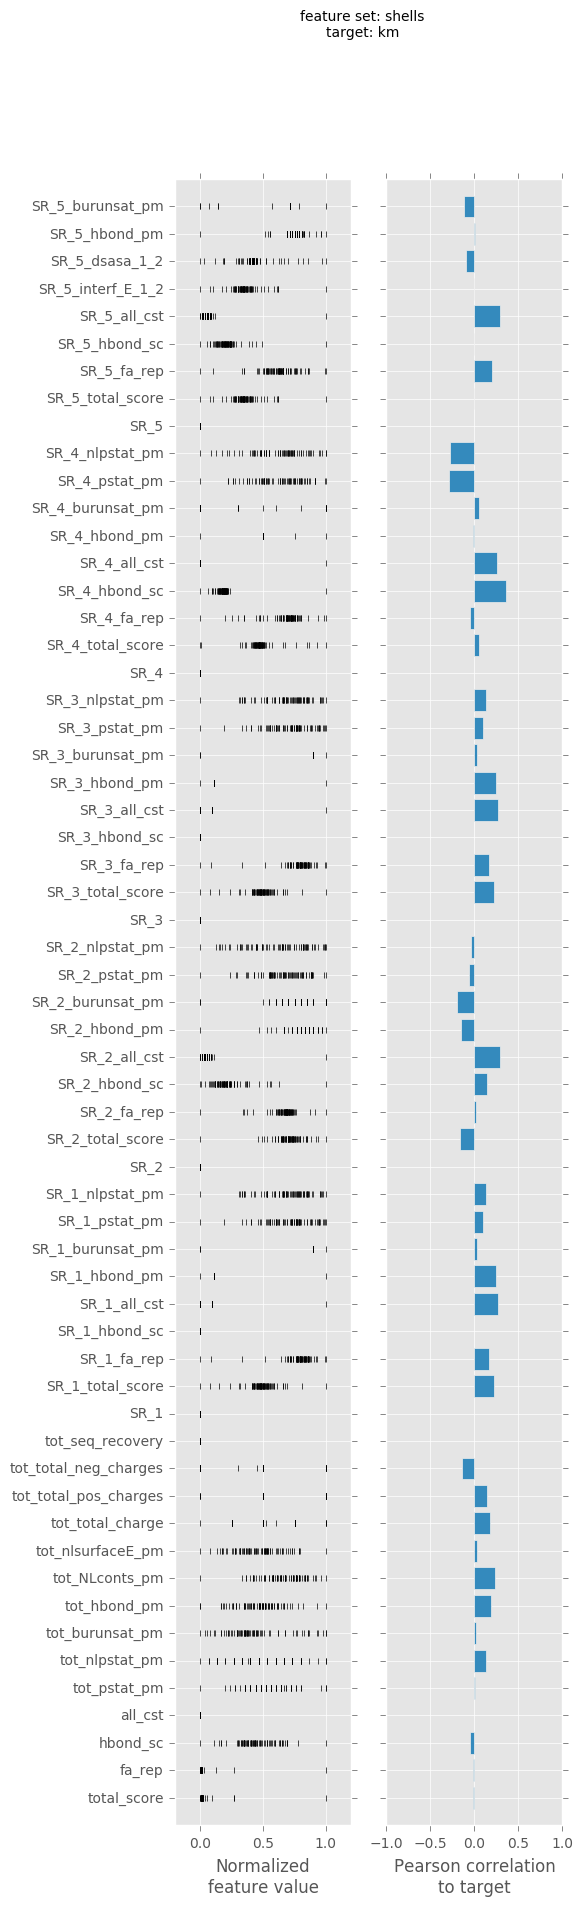

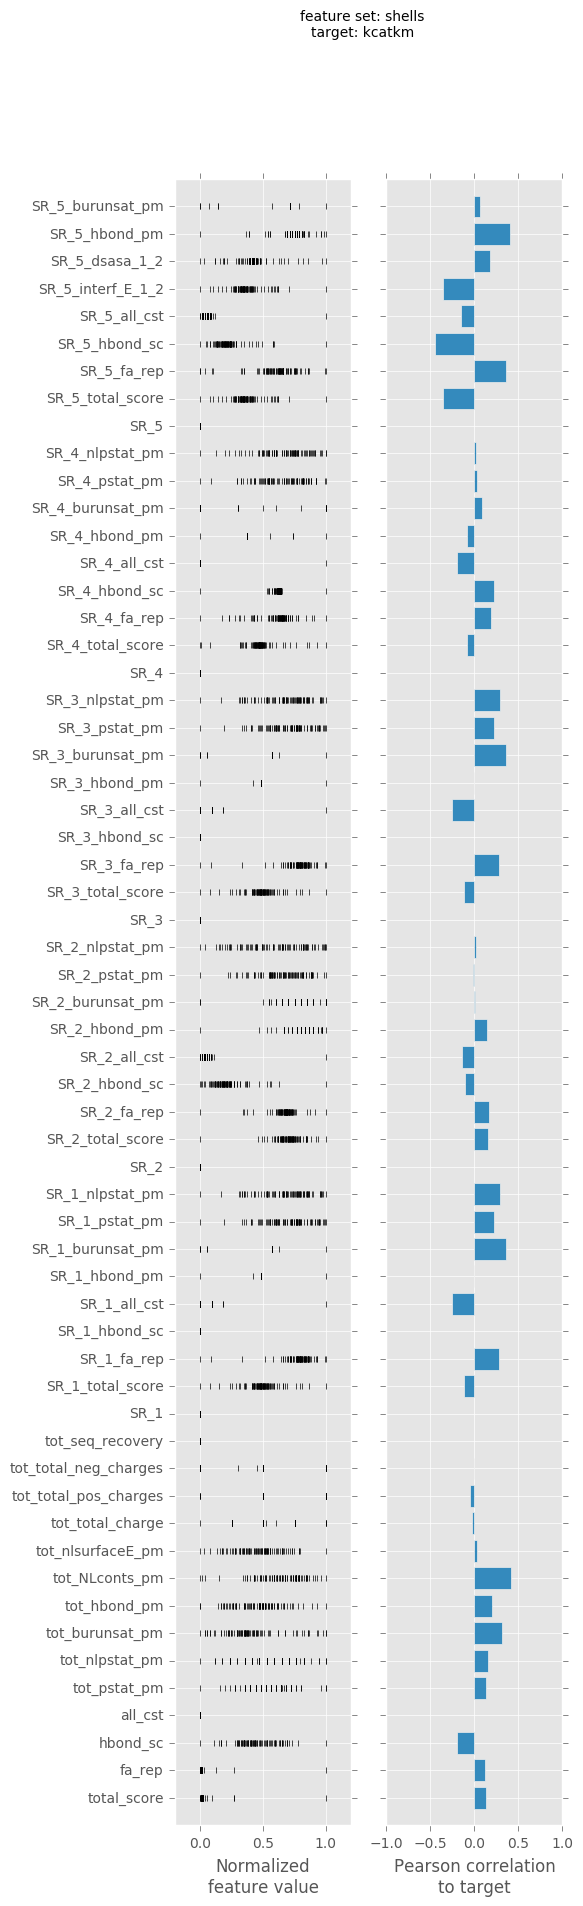

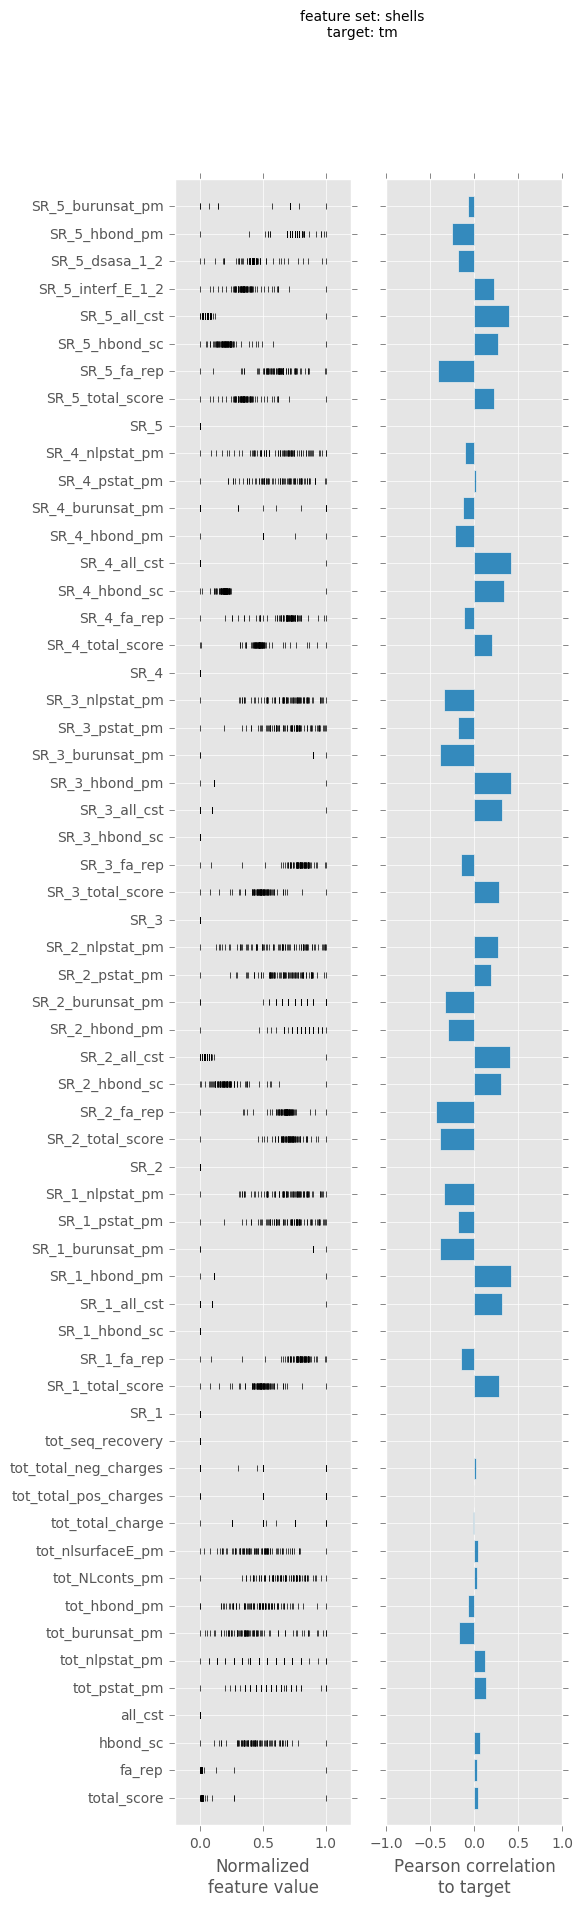

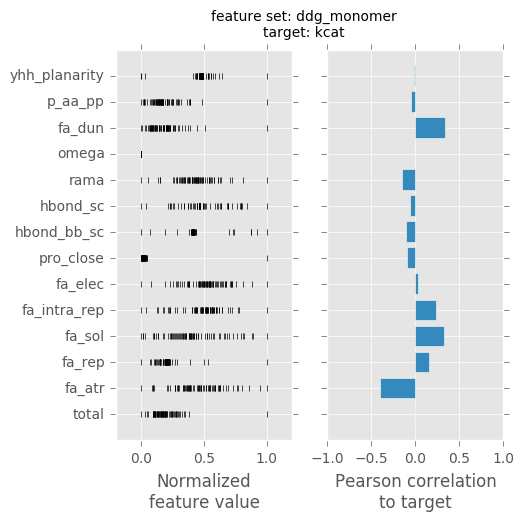

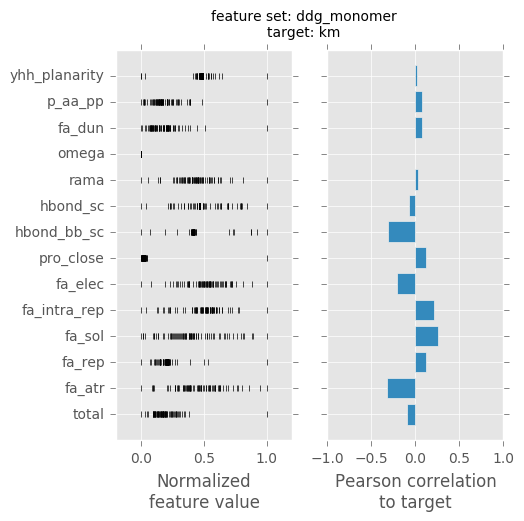

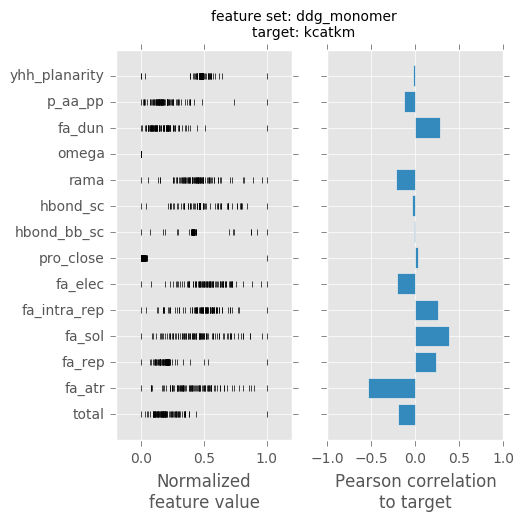

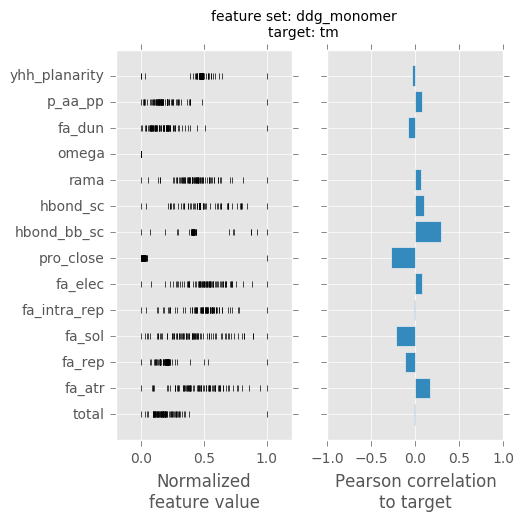

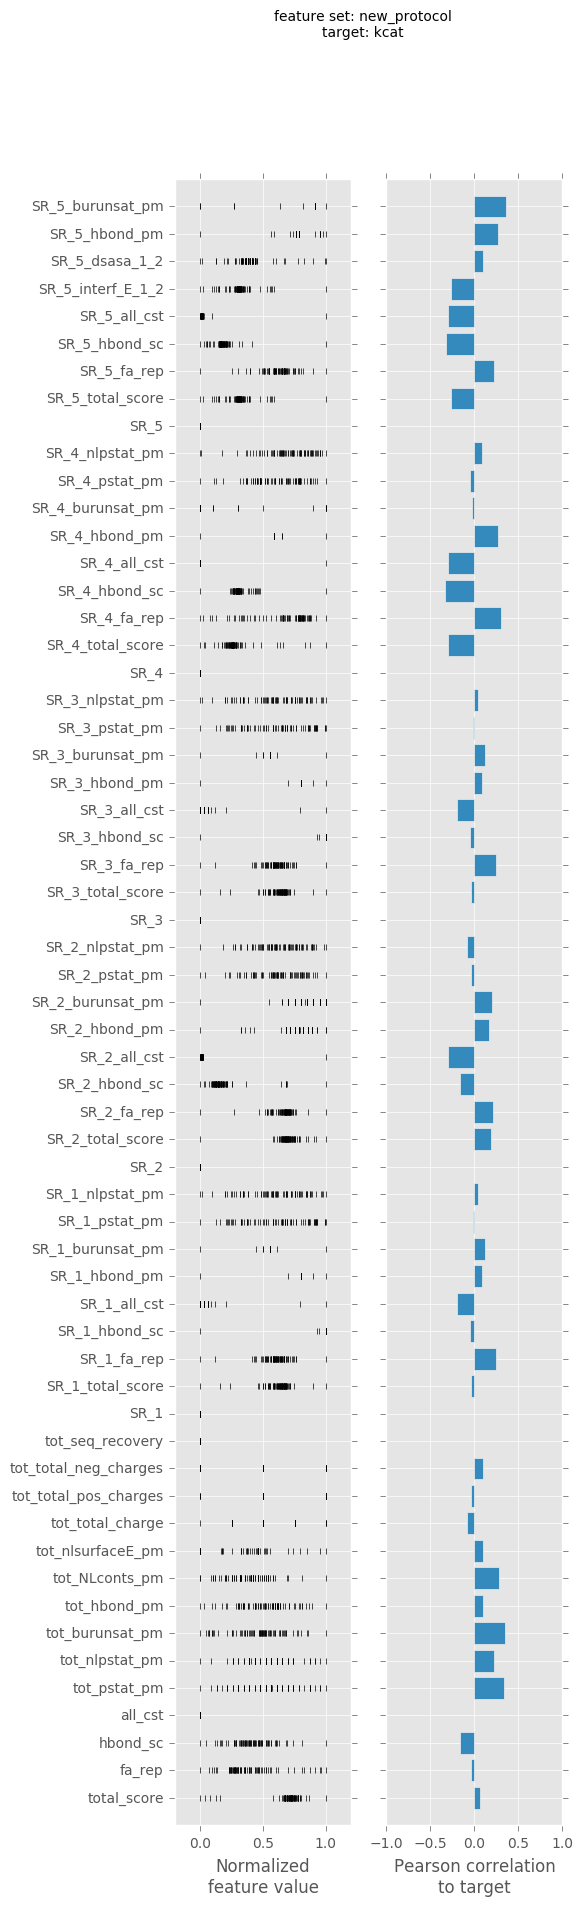

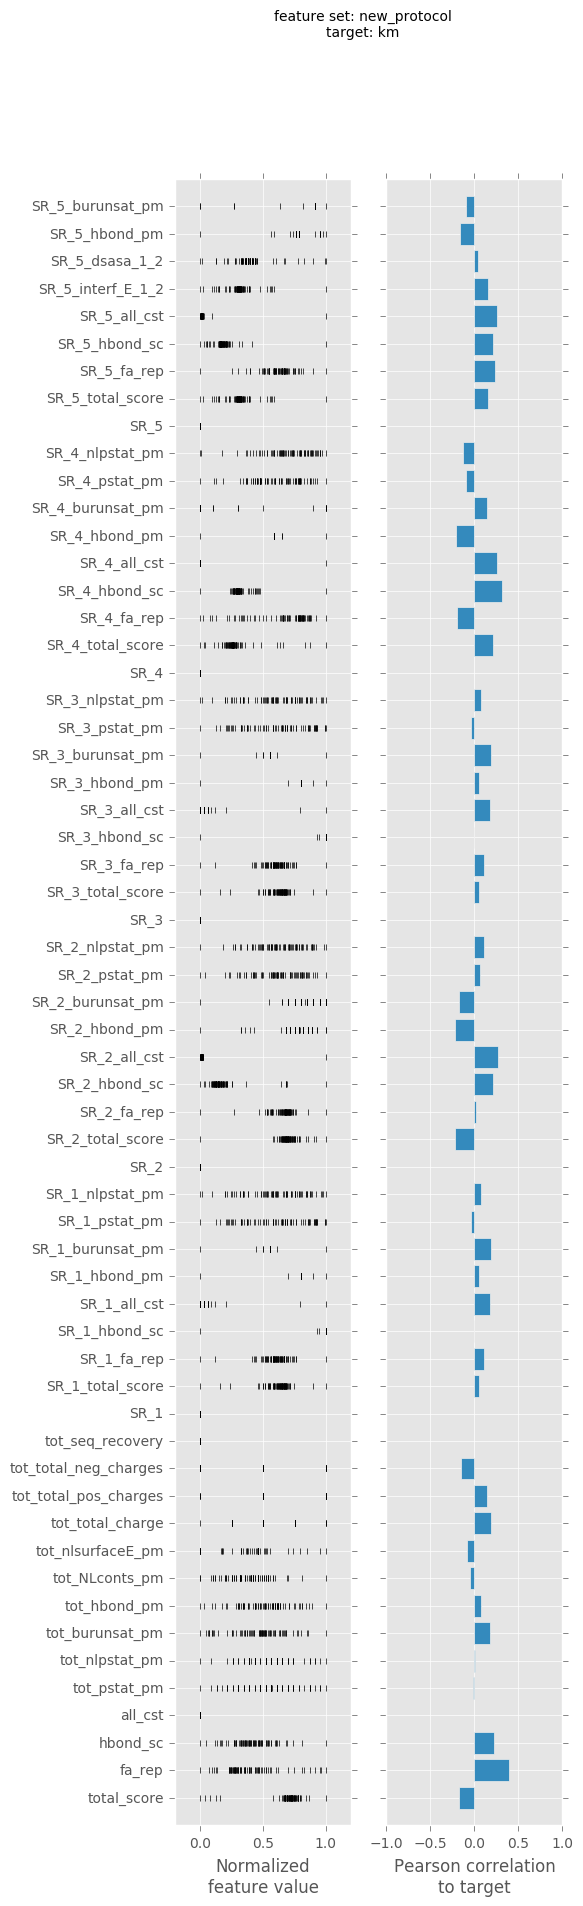

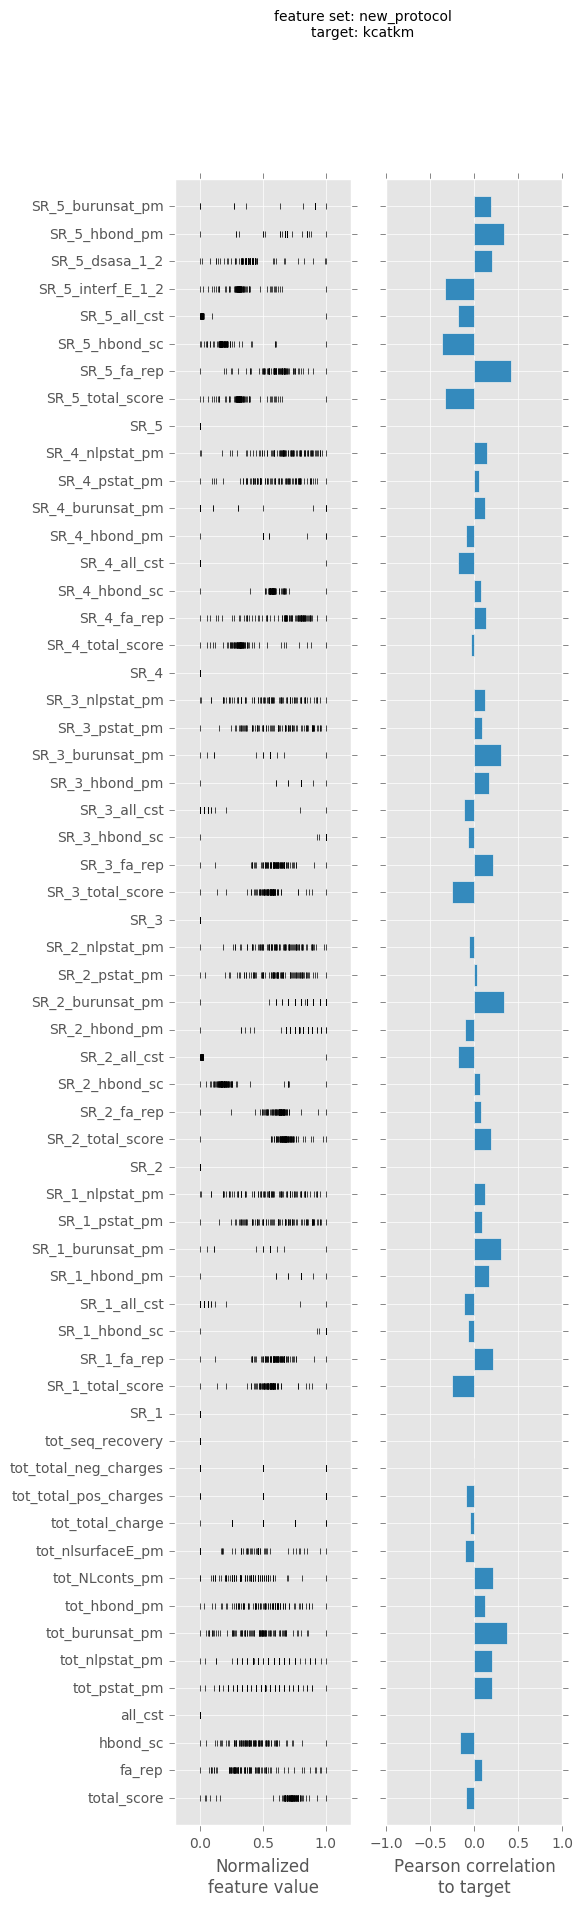

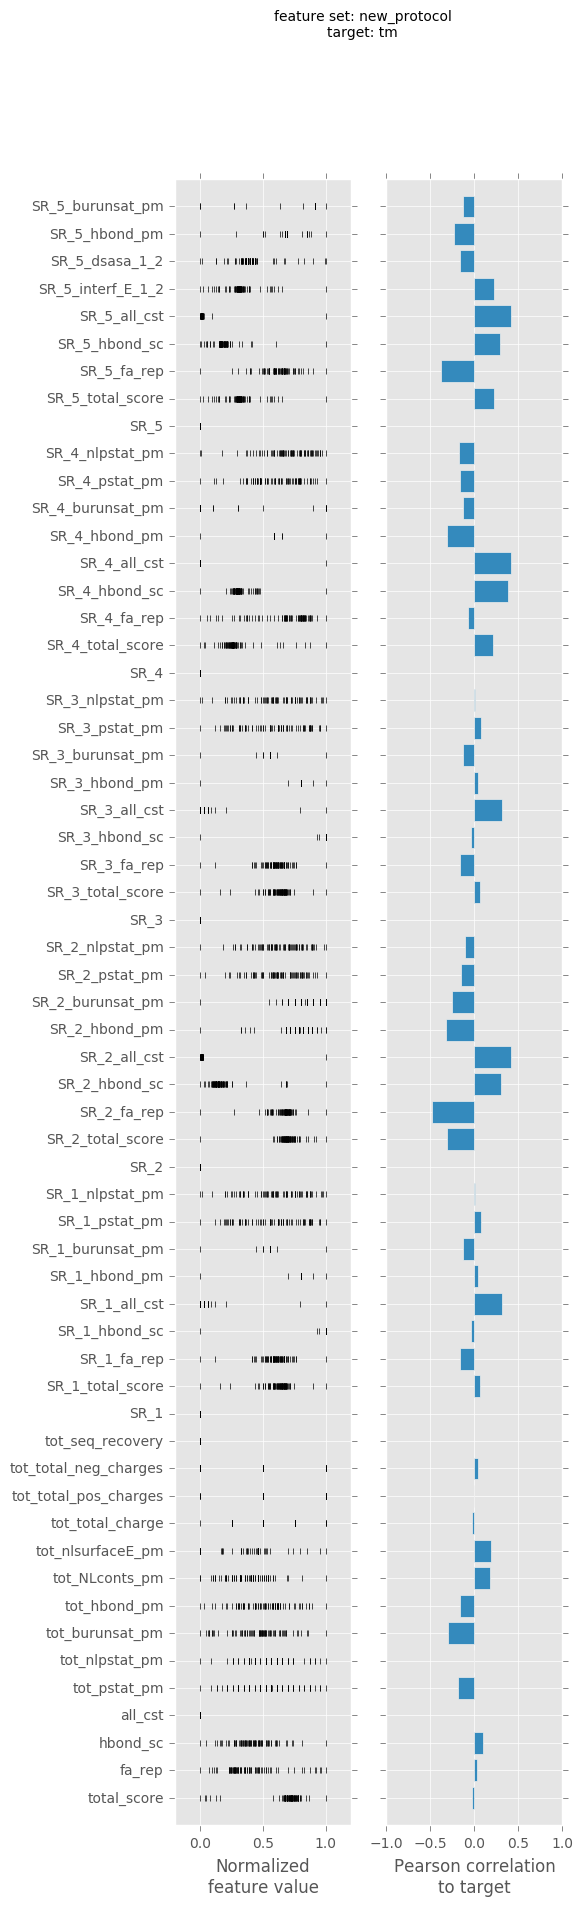

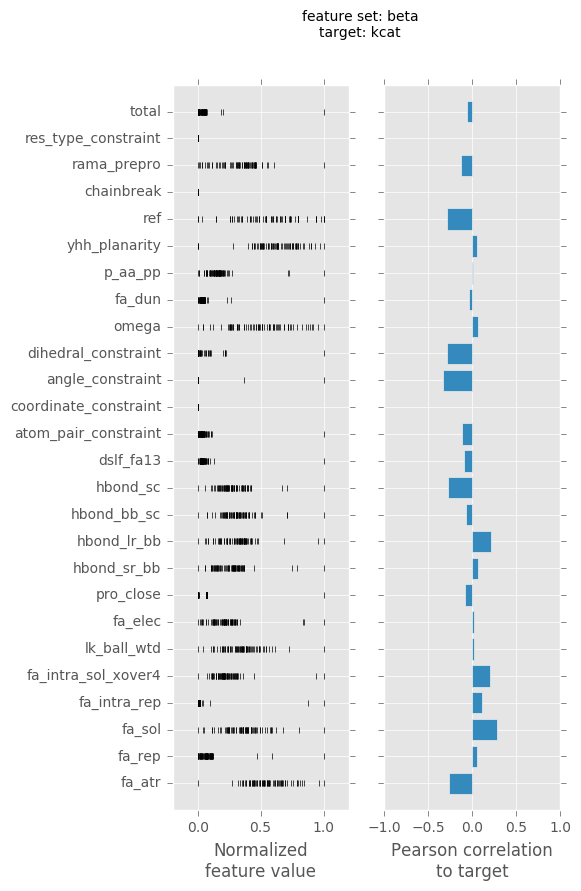

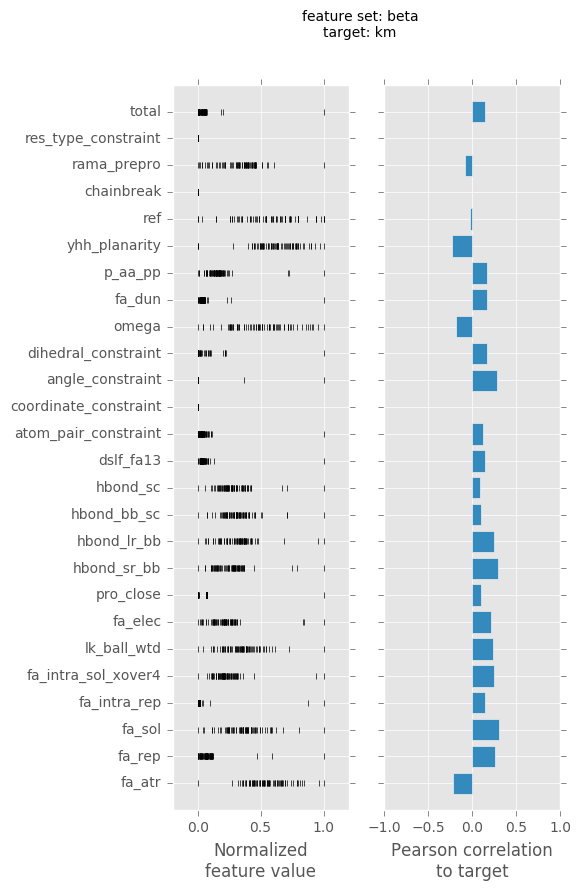

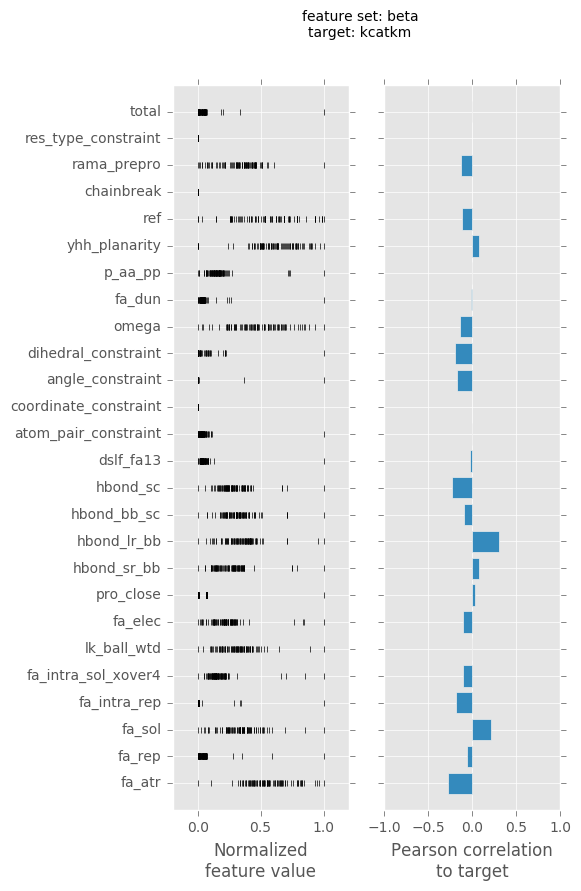

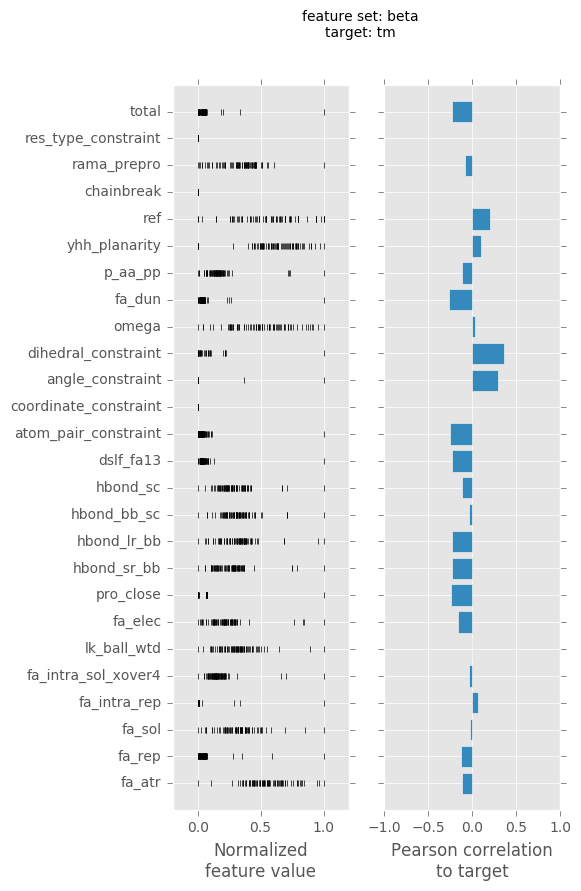

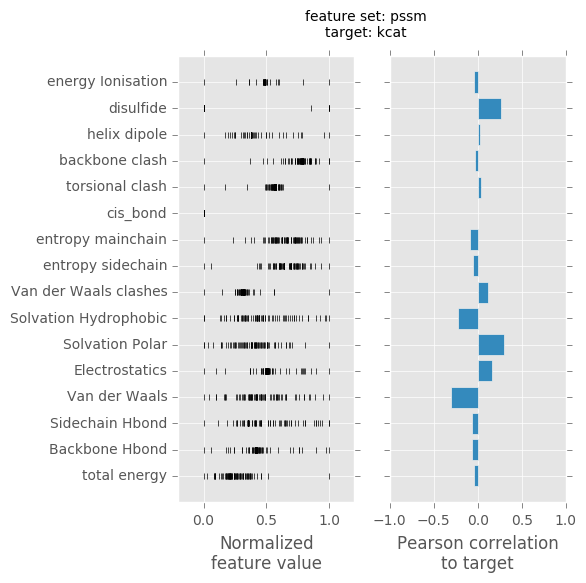

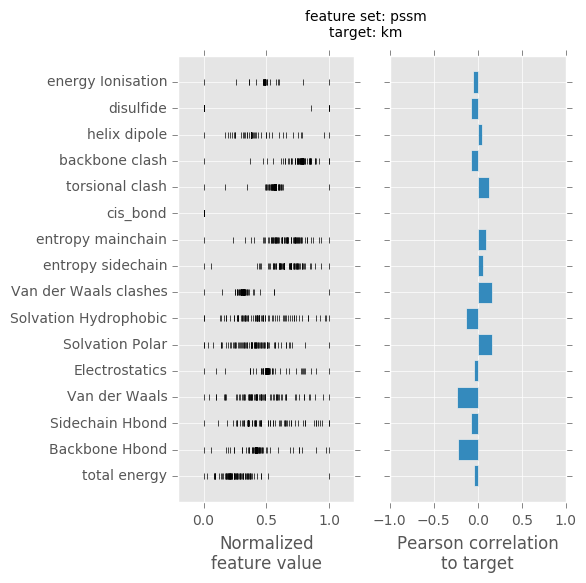

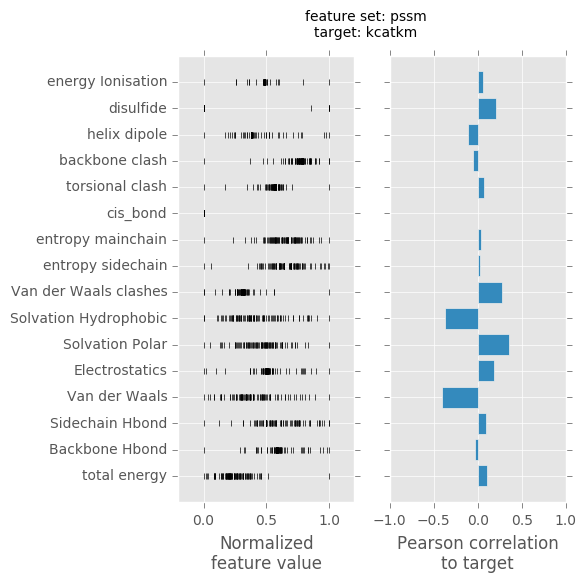

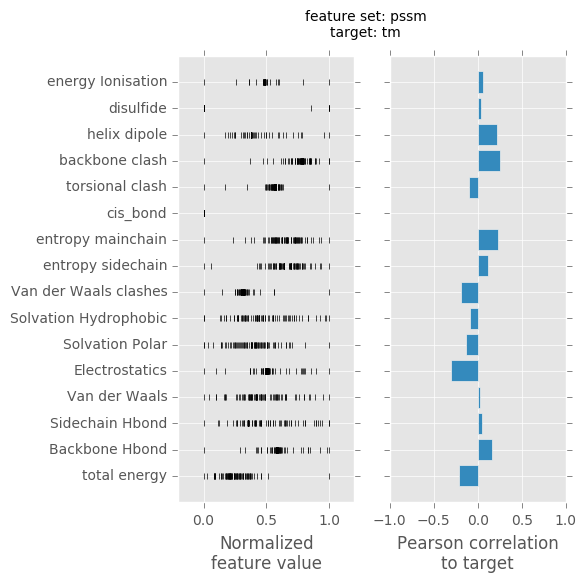

In [24]:
for name, target, X, y, support in combos: 
    
    fig, ax = plt.subplots( nrows=1, ncols=2, sharey=True, figsize=( 5, 0.36 * len( support ) ) )
        
    support_vals = []
    rr = []
    for i, col_name in enumerate( support ):
        ax[ 0 ].scatter( X[ : , i ], [ i ] * len( X ), marker='|', color='k' )
        ax[ 0 ].set_ylim( -1, len( support ) )
        r, p = pearsonr( X[ : , i ], y )
        rr.append( r ) 
        #support_vals.append( '{} ({})'.format( col_name, r.round(2) ) )
        support_vals.append( '{}'.format( col_name ) )
        
    ax[ 0 ].set_yticks( range( len( support_vals ) ) )
    ax[ 0 ].set_yticklabels( support_vals )
    ax[ 0 ].set_xticks( ( 0, .5, 1 ) )
    ax[ 0 ].set_xlabel( 'Normalized\nfeature value' )
    
    ax[ 1 ].barh( range( len( support_vals ) ), rr, align='center' ) 
    ax[ 1 ].set_xlim( ( -1, 1 ) )
    ax[ 1 ].set_xlabel( 'Pearson correlation\nto target' )
    
    fig.suptitle( 'feature set: {}\ntarget: {}'.format( name, target ) )

## Next steps 

Now that we have an idea of the feature space, we can try training some machine learning algorithms to predict the experimental targets from the computational features. 

See notebooks `elastic_net`, `elastic_net_with_bagging`, and `predicting_soluble_expression` in this repo. 